<a href="https://colab.research.google.com/github/Jin-jin-jara/Small-Project1---two_digits_with_blank_classification/blob/master/small_project1_two_digits_with_blank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# small project - two digits with blank classification

In [1]:
# tensorflow 버전 2를 사용합니다.
%tensorflow_version 2.x

# 모델을 만들기 위한 라이브러리
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, LSTM, Reshape, Activation, Dropout
from tensorflow.keras import Model
from keras import optimizers

# 데이터 가공과 시각화를 위한 라이브러리
import numpy as np
import matplotlib.pyplot as plt

TensorFlow 2.x selected.


Using TensorFlow backend.


In [2]:
# 이번 프로젝트에서 사용할 데이터셋
from sklearn.datasets import load_digits

x, y = load_digits(return_X_y=True)

# 1797개의 8*8 이미지들. 각 이미지들은 0~9까지의 숫자입니다.
x.shape, y.shape, set(y)

((1797, 64), (1797,), {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})

데이터를 train 셋과 test셋을 나눕니다. train 셋과 test셋을 또 절반으로 나눠 좌우로 붙일 것이기 때문에 짝수개의 이미지가 필요합니다.하지만 전체 데이터는 홀수개이기 때문에 마지막 한 개는 사용하지 않겠습니다.

In [3]:
m = len(x)//2
x_train = x[:m]
y_train = y[:m]
x_test = x[m:m*2]
y_test = y[m:m*2]

x_train.shape, x_test.shape

((898, 64), (898, 64))

데이터를 반으로 나누고 좌우로 붙이는 함수입니다. 오른쪽 이미지에는 빈 이미지도 추가합니다. 정답인 label 또한 비슷한 작업을 해줍니다.

In [0]:
def convert_2_num(x_data, y_data):
  x_data = np.reshape(x_data, [-1, 8, 8])
  x_data_l, x_data_r = np.split(x_data, 2, axis=0)
  x_data_lr = np.concatenate((x_data_l, x_data_r), axis=2)
  y_data_l, y_data_r = np.split(y_data, 2, axis=0)
  y_data = np.stack((y_data_l, y_data_r), -1)

  BLANK = 10  # 없음을 뜻하는 기호

  x_data_blank = np.concatenate((x_data_l, np.zeros_like(x_data_r)), axis=2)
  y_data_blank = np.stack((y_data_l, np.zeros_like(y_data_l)+BLANK), 1)

  x_data_set = np.concatenate((x_data_lr, x_data_blank), 0)
  y_data_set = np.concatenate((y_data, y_data_blank), 0)

  return x_data_set, y_data_set

각 이미지당 8x16 픽셀의 데이터가 만들어졌습니다. train, test 각각 898개의 이미지를 갖고 있습니다.

In [5]:
x_train_set, y_train_set = convert_2_num(x_train, y_train)
x_test_set, y_test_set = convert_2_num(x_test, y_test)
x_train_set.shape, x_test_set.shape

((898, 8, 16), (898, 8, 16))

만든 숫자 이미지가 좌우에 잘 붙었나 살펴보겠습니다.

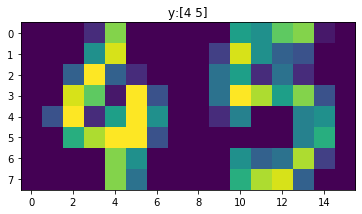

In [6]:
i = 100
plt.title("y:"+str(y_train_set[i]))
plt.imshow(x_train_set[i])

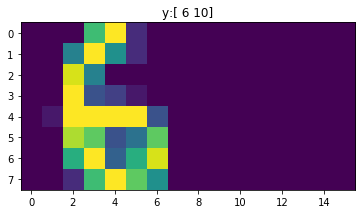

In [7]:
i = 800
plt.title("y:"+str(y_train_set[i]))
plt.imshow(x_train_set[i])

숫자가 양 옆으로 잘 붙었습니다. 숫자 이미지와 한쪽이 빈 공간인 데이터도 잘 출력됩니다.

CNN모델은 4차원(데이터수(m), 너비(w), 높이(h), 채널(c))의 데이터를 입력으로 받습니다. 하지만 만들어진 데이터셋은 (데이터수, 너비, 높이)만 있으므로 채널 차원을 추가해줍니다. 채널은 1로 사용하겠습니다.

In [8]:
x_train_set = x_train_set[..., tf.newaxis]
x_test_set = x_test_set[..., tf.newaxis]
x_train_set.shape, x_test_set.shape

((898, 8, 16, 1), (898, 8, 16, 1))

In [9]:
x_train_set.shape, x_test_set.shape, y_train_set.shape, y_test_set.shape

((898, 8, 16, 1), (898, 8, 16, 1), (898, 2), (898, 2))

배치 사이즈를 정하고 데이터를 데이터 소스로 만듭니다.

In [0]:
BATCH_SIZE = 32

train_ds = tf.data.Dataset.from_tensor_slices((x_train_set, y_train_set)).shuffle(10000).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((x_test_set, y_test_set)).shuffle(10000).batch(BATCH_SIZE)

## Sequential을 이용한 CNN 모델

첫 번째 모델은 keras의 Sequential을 사용해 만들어보겠습니다. keras에서 제공하는 Sequential 모델로 딥러닝 네트워크를 아주 쉽게 만들 수 있습니다.

In [17]:
def build_model():
  model = keras.Sequential()
  model.add(Conv2D(32, 3, padding="same", input_shape=(8, 16, 1)))
  model.add(MaxPool2D(2, padding="same"))
  model.add(Conv2D(32, 3, padding="same"))
  model.add(MaxPool2D(2, padding="same"))
  model.add(Conv2D(32, 3, padding="same"))
  model.add(MaxPool2D(2, padding="same"))
  model.add(Flatten())
  model.add(Dense(64, activation='relu'))
  model.add(Dense(22))
  model.add(Reshape((2, 11)))  # (m, 2, 11)
  model.add(Activation('softmax'))
  adam = tf.keras.optimizers.Adam(lr = 0.001)
  model.compile(loss="sparse_categorical_crossentropy", optimizer=adam, metrics=['accuracy'])
  model.summary()
  return model

model = build_model()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 8, 16, 32)         320       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 4, 8, 32)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 4, 8, 32)          9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 2, 4, 32)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 2, 4, 32)          9248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 64)               

In [18]:
model.fit(x_train_set, y_train_set, batch_size = 32, epochs=100, validation_split=0.3,shuffle=True, verbose=0)

In [0]:
loss_metrics = model.evaluate(x_test_set, y_test_set,batch_size=32)
print('evaluation loss and_metrics')
print(loss_metrics)

898/898 [==============================] - 0s 79us/sample - loss: 0.3431 - accuracy: 0.9271
evaluation loss and_metrics
[0.34310407153229494, 0.9270601]


train 셋에 대한 정확도는 거의 100%에 가깝고 test 셋의 정확도는 92.7%가 나옵니다.

## 텐서플로 2.0 시작하기: 전문가용
이번에는 직접 모델을 설계해보겠습니다. 이 모델은 tensorflow 홈페이지의 전문가용 코드를 참고해 만들었습니다. (https://www.tensorflow.org/tutorials/quickstart/advanced?hl=ko)

### model

In [0]:
class MyModel(Model): 
  def __init__(self):
    super(MyModel, self).__init__()
    self.k = 11     # 클래스 개수 (0 ~ 10까지, 10은 빈 이미지를 뜻함)
    self.seq = 2     # 자리수 (오른쪽, 왼쪽 두 자리를 예측해야함)
    self.conv1 = Conv2D(32, 3, padding="same")
    self.pool1 = MaxPool2D(2, padding="same")
    self.conv2 = Conv2D(32, 3, padding='same')
    self.pool2 = MaxPool2D(2, padding="same")
    self.conv3 = Conv2D(32, 3, padding='same')
    self.pool3 = MaxPool2D(2, padding="same")
    self.flatten = Flatten()
    self.d1 = Dense(128, activation="relu")
    self.d2 = Dense(self.k*self.seq)   # 22

  def call(self, x):
    # (m, 8, 16, 1)
    x = self.conv1(x) 
    x = self.pool1(x)  # (m, 4, 8, 32)
    x = self.conv2(x)
    x = self.pool2(x)  # (m, 2, 4, 32)
    x = self.conv3(x)
    x = self.pool3(x)  # (m, 1, 2, 32)
    x = self.flatten(x)  # (m, 64)
    x = self.d1(x)   # (m, 128)
    h = self.d2(x)  # (m, 22)
    # 두 자리 숫자 [0~10, 0~10]에 대한 예측을 진행해야 하므로 reshape해줍니다.
    h = tf.reshape(h, [-1, self.seq, self.k]) # (m, 2, 11)
    h = tf.nn.softmax(h, axis=2)   
    return h

model = MyModel()

loss function, optimizer, metrics를 설정해줍니다.

In [0]:
# 분류에 관한 문제이기 때문에 cross entropy함수를 비용 함수로 사용합니다.
# label을 one-hot encoding 했기 때문에 SparseCategoricalCrossentropy 함수가 아닌 CategoricalCrossentropy 함수를 사용합니다.
loss_object = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

train_loss = tf.keras.metrics.Mean(name="train_loss")
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name="train_acc")

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name="test_acc")

train과 test를 위한 함수입니다.

In [0]:
@tf.function
def train_step(images, labels):
  y_hot = tf.one_hot(labels, depth=11, axis=-1)
  with tf.GradientTape() as tape:
    predictions = model(images) # (m, 8, 16, 1)
    loss = loss_object(y_hot, predictions)
  grads = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

  train_loss(loss)
  train_accuracy(y_hot, predictions)

In [0]:
@tf.function
def test_step(images, labels):
  y_hot = tf.one_hot(labels, depth=11, axis=-1)
  predictions = model(images)
  t_loss = loss_object(y_hot, predictions)

  test_loss(t_loss)
  test_accuracy(y_hot, predictions)

In [0]:
EPOCHS = 800

for epoch in range(EPOCHS):
  for images, labels in train_ds: # batch size = 32씩 나눠져 들어갑니다
    train_step(images, labels)
  
  for test_images, labels in test_ds:
    test_step(test_images, labels)
  
  template = "에포크: {}, 손실: {}, 정확도: {}, 테스트 손실: {}, 테스트 정확도: {}"
  
  if epoch%40==0:
    print(template.format(epoch,
                          train_loss.result(),
                          train_accuracy.result()*100,
                          test_loss.result(),
                          test_accuracy.result()*100))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

에포크: 0, 손실: 1.8129262924194336, 정확도: 39.587974548339844, 테스트 손실: 1.4180071353912354, 테스트 정확도: 56.2917594909668
에포크: 40, 손실: 0.0986887514591217, 정확도: 97.044921875, 테스트 손실: 0.3657163381576538, 테스트 정확도: 90.64452362060547
에포크: 80, 손실: 0.050039589405059814, 정확도: 98.50421905517578, 테스트 손실: 0.358181893825531, 테스트 정확도: 91.83782958984375
에포크: 120, 손실: 0.03351296856999397, 정확도: 98.99869537353516, 테스트 손실: 0.3692639470100403, 테스트 정확도: 92.25689697265625
에포크: 160, 손실: 0.02519114315509796, 정확도: 99.24746704101562, 테스트 

train 정확도 99.8%, 테스트 정확도 93.2%로 준수합니다. 하지만 overfitting이 일어난 것 같으니 dropout기법을 적용하여 test 정확도를 조금 더 올려보겠습니다.

### model2 : dropout

모델의 overfitting을 방지하기 위해 dropout층을 추가했습니다.

In [0]:
class MyModel(Model): 
  def __init__(self):
    super(MyModel, self).__init__()
    self.k = 11     
    self.seq = 2    
    self.conv1 = Conv2D(32, 3, padding="same")
    self.pool1 = MaxPool2D(2, padding="same")
    self.conv2 = Conv2D(32, 3, padding='same')
    self.pool2 = MaxPool2D(2, padding="same")
    self.conv3 = Conv2D(32, 3, padding='same')
    self.pool3 = MaxPool2D(2, padding="same")
    self.dropout = Dropout(rate=0.5)    # 추가한 부분
    self.flatten = Flatten()
    self.d1 = Dense(128, activation="relu")
    self.d2 = Dense(self.k*self.seq) 

  def call(self, x):
    x = self.conv1(x) 
    x = self.pool1(x)  
    x = self.dropout(x)  # 추가한 부분
    x = self.conv2(x)
    x = self.pool2(x) 
    x = self.dropout(x)   # 추가한 부분
    x = self.conv3(x)
    x = self.pool3(x)  
    x = self.flatten(x)
    x = self.d1(x)
    x = self.dropout(x)   # 추가한 부분
    h = self.d2(x) 
    h = tf.reshape(h, [-1, self.seq, self.k])
    h = tf.nn.softmax(h, axis=2)   
    return h

model = MyModel()

In [0]:
loss_object = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

train_loss = tf.keras.metrics.Mean(name="train_loss")
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name="train_acc")

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name="test_acc")

In [0]:
@tf.function
def train_step(images, labels):
  y_hot = tf.one_hot(labels, depth=11, axis=-1)
  with tf.GradientTape() as tape:
    predictions = model(images) # (m, 8, 16, 1)
    loss = loss_object(y_hot, predictions)
  grads = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

  train_loss(loss)
  train_accuracy(y_hot, predictions)

In [0]:
@tf.function
def test_step(images, labels):
  y_hot = tf.one_hot(labels, depth=11, axis=-1)
  predictions = model(images)
  t_loss = loss_object(y_hot, predictions)

  test_loss(t_loss)
  test_accuracy(y_hot, predictions)

In [0]:
EPOCHS = 800

for epoch in range(EPOCHS):
  for images, labels in train_ds: # batch size = 32씩 나눠져 들어갑니다
    train_step(images, labels)
  
  for test_images, labels in test_ds:
    test_step(test_images, labels)
  
  template = "에포크: {}, 손실: {}, 정확도: {}, 테스트 손실: {}, 테스트 정확도: {}"
  
  if epoch%40==0:
    print(template.format(epoch,
                          train_loss.result(),
                          train_accuracy.result()*100,
                          test_loss.result(),
                          test_accuracy.result()*100))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

에포크: 0, 손실: 1.691123127937317, 정확도: 42.093544006347656, 테스트 손실: 1.3450655937194824, 테스트 정확도: 58.57461166381836
에포크: 40, 손실: 0.09106644988059998, 정확도: 97.2812271118164, 테스트 손실: 0.3153878152370453, 테스트 정확도: 91.75267791748047
에포크: 80, 손실: 0.04617966338992119, 정확도: 98.62383270263672, 테스트 손실: 0.30044013261795044, 테스트 정확도: 92.94316864013672
에포크: 120, 손실: 0.03092942200601101, 정확도: 99.07876586914062, 테스트 손실: 0.30383631587028503, 테스트 정확도: 93.38520812988281
에포크: 160, 손실: 0.023249594494700432, 정확도: 99.307640075683

dropout을 cnn층 중간중간에 추가했더니 train 정확도는 99.8%로 거의 변화하지 않았지만 test 정확도는 94.12%로 올랐습니다! 직접 커스터마이징한 모델이 Sequential 모델만큼 잘 작동하는 것 같습니다.